Notebook purpose

- Explore entropy scores

In [18]:
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

sys.path.append('/Users/fgu/dev/projects/entropy')
from entropy import config
import entropy.helpers.aws as aws
import entropy.data.helpers as hr
import entropy.data.cleaners as cl
import entropy.data.creators as cr
import entropy.figures.figures as figs

sns.set_style('whitegrid')
pd.set_option('display.max_rows', 120)
pd.set_option('display.max_columns', 120)
pd.set_option('max_colwidth', None)
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
SAMPLE = '000'
fp = f'~/tmp/entropy_{SAMPLE}.parquet'

df = aws.read_parquet(fp)
df.head(2)

,id,date,user_id,amount,desc,merchant,tag_group,tag,user_female,user_postcode,user_registration_date,user_salary_range,user_yob,account_created,account_id,account_last_refreshed,account_provider,account_type,data_warehouse_date_created,data_warehouse_date_last_updated,debit,latest_balance,merchant_business_line,savings,tag_auto,tag_manual,tag_up,updated_flag,ym
0,688283,2012-01-17,777,42.410000,9572 16jan 12 esso altrincham sstn altrincham gb,esso,spend,motor,False,wa1 4,2011-07-20,20k to 30k,1969.0,2011-07-20,262916,2020-06-25 22:55:00,natwest bank,current,2014-07-18,2017-08-15,True,2378.280029,esso,False,fuel,NaN,fuel,u,201201
1,248375,2012-07-23,777,39.389999,9572 20jul 12 sacat marks spencer gemini gb cash back 30 00,NaN,spend,other_spend,False,wa1 4,2011-07-20,20k to 30k,1969.0,2011-07-20,262916,2020-06-25 22:55:00,natwest bank,current,2014-07-18,2017-10-23,True,2378.280029,personal,False,cash,groceries,groceries,u,201207


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 995 entries, 0 to 994
Data columns (total 29 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   id                                995 non-null    int32         
 1   date                              995 non-null    datetime64[ns]
 2   user_id                           995 non-null    int32         
 3   amount                            995 non-null    float32       
 4   desc                              995 non-null    category      
 5   merchant                          480 non-null    category      
 6   tag_group                         780 non-null    category      
 7   tag                               781 non-null    category      
 8   user_female                       971 non-null    object        
 9   user_postcode                     995 non-null    category      
 10  user_registration_date            995 non-null    

In [165]:
df['user_gender'] = df.user_gender.where(df.user_gender.ne('u'), None)
df.user_gender.value_counts(dropna=False)

AttributeError: 'DataFrame' object has no attribute 'user_gender'

In [157]:
(df.user_gender == 'f').value_counts(dropna=False)

False    579
True     416
Name: user_gender, dtype: int64

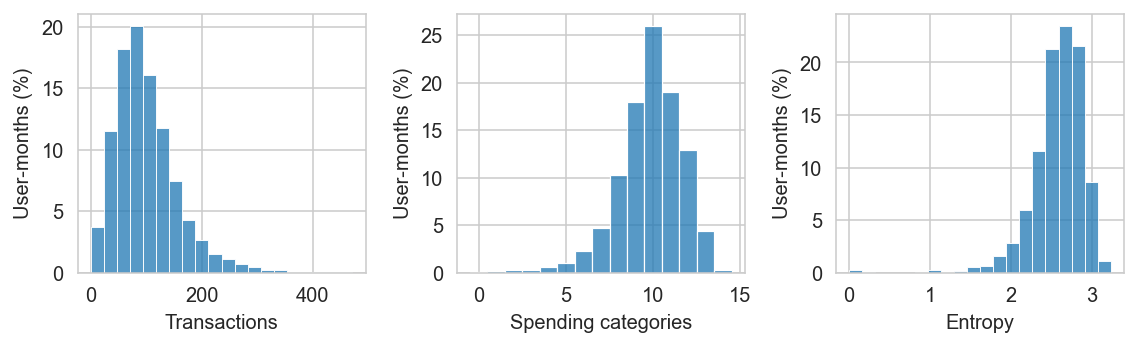

In [51]:
figs.txns_distrs(df, write=False)

In [65]:
data = df.groupby(['user_id', 'ym'], as_index=False).entropy_tag.first()
data.head()

,user_id,ym,entropy_tag
0,777,201201,2.847520
1,777,201202,2.665994
2,777,201204,2.561278
3,777,201205,2.887899
4,777,201206,2.686708


Distribution of user-level std

In [111]:
from scipy.stats import entropy

def calc_entropy(df):
    """Return Shannon Entropy.

    Calculated at user-month level, based on `tag` and optionally
    additional columns.
    """
    def calc_entropy(g, num_cats):
        total_txns = len(g)
        txns_by_cat = g.groupby(c).size()
        prop_by_cat = (txns_by_cat + 1) / (total_txns + num_cats)
        return entropy(prop_by_cat, base=2)

    g = df[df.debit].groupby(['user_id', 'ym'])
    cols = ['tag']

    for c in cols:
        col_name = '_'.join(['entropy', c])
        num_cats = df[c].nunique()

        scores = (g.apply(calc_entropy, num_cats)
                  .rename(col_name)
                  .reset_index())
        df = df.merge(scores, validate='m:1') 

    return df


a = calc_entropy(df)


def calc_entropy2(df):
    """Return Shannon Entropy.

    Calculated at user-month level, based on `tag` and optionally
    additional columns.
    
    - new vars as cat
    - only spend
    - simpler helper
    
    """
    
    def calc_entropy(g, num_cats):
        total_txns = g.size()
        txns_by_cat = g.value_counts()
        prop_by_cat = (txns_by_cat + 1) / (total_txns + num_cats)
        
        return entropy(prop_by_cat, base=2)

    cols = ['tag']

    for c in cols:
        col_name = '_'.join(['entropy', c])
        num_cats = df[c].nunique()
        
        g = df[df.tag_group.eq('spend')].groupby(['user_id', 'ym']).tag


        
        scores = (g.apply(calc_entropy, num_cats)
                  .rename(col_name)
                  .reset_index())
        df = df.merge(scores, validate='m:1') 

    return df

In [138]:
a = pd.DataFrame({'gender':['m', 'm', 'u', 'f', 'u', 'f']})
a

,gender
0,m
1,m
2,u
3,f
4,u
5,f


In [134]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 673256 entries, 0 to 673255
Data columns (total 33 columns):
 #   Column                            Non-Null Count   Dtype         
---  ------                            --------------   -----         
 0   id                                673256 non-null  int32         
 1   date                              673256 non-null  datetime64[ns]
 2   user_id                           673256 non-null  int32         
 3   amount                            673256 non-null  float32       
 4   desc                              673256 non-null  object        
 5   merchant                          365540 non-null  category      
 6   tag_group                         533465 non-null  object        
 7   tag                               537320 non-null  object        
 8   user_female                       603894 non-null  object        
 9   user_postcode                     673256 non-null  category      
 10  user_registration_date          

In [123]:
df[df.tag_group.eq('spend')].groupby(['user_id', 'ym']).tag.value_counts()

user_id  ym      tag          
777      201201  household        7
                 finance          6
                 other_spend      6
                 services         5
                 motor            2
                                 ..
587177   202007  motor            7
                 hobbies          6
                 other_spend      3
                 communication    2
                 retail           2
Name: tag, Length: 49934, dtype: int64

In [107]:
hr.lloyds_spend.keys()

dict_keys(['communication', 'finance', 'hobbies', 'household', 'motor', 'retail', 'services', 'travel', 'other_spend'])

In [105]:
set(list(hr.tag_groups.keys()) + [None])

['income', 'spend', 'transfers', None]

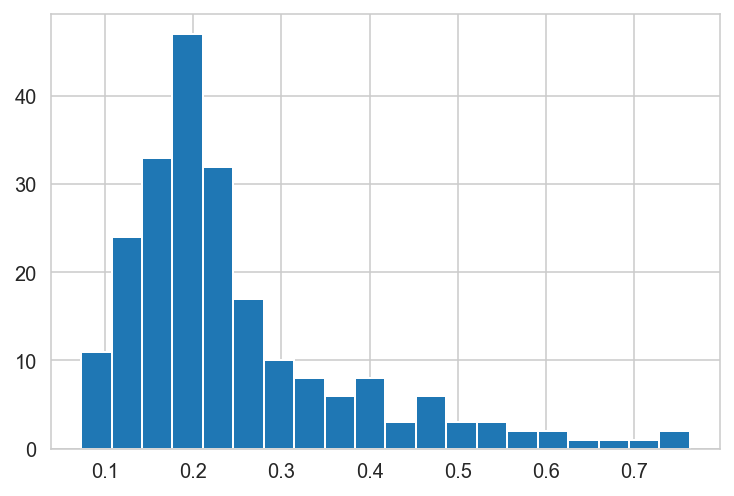

In [67]:
data.groupby('user_id').entropy_tag.std().hist(bins=20);

Patterns year-to-year (would expect to be stable)

<AxesSubplot:xlabel='ym', ylabel='entropy_tag'>

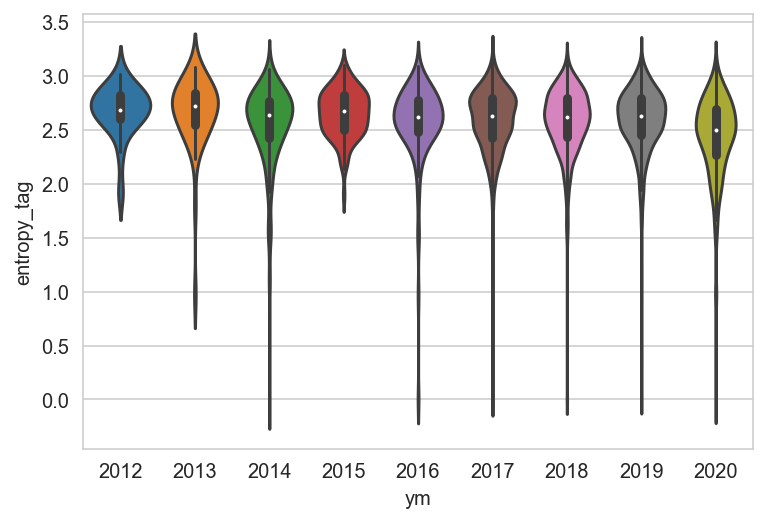

In [73]:
sns.violinplot(data=data, x=data.ym // 100, y='entropy_tag')

In [77]:
df[df.tag_group.eq('spend')].tag.unique()

array(['services', 'household', 'finance', 'other_spend', 'retail',
       'motor', 'communication', 'travel', 'hobbies', 'transfers'],
      dtype=object)

In [82]:
df.tag_group.unique()

array(['transfers', 'spend', None, 'income'], dtype=object)

In [74]:
df[df.entropy_tag == 0]

,id,date,user_id,amount,desc,merchant,tag_group,tag,user_female,user_postcode,user_registration_date,user_salary_range,user_yob,account_created,account_id,account_last_refreshed,account_provider,account_type,data_warehouse_date_created,data_warehouse_date_last_updated,debit,latest_balance,merchant_business_line,savings,tag_auto,tag_manual,tag_up,updated_flag,ym,balance,income,entropy_tag_auto,entropy_tag
19447,22430484,2014-05-30,68877,7.600000,oliver spar 2905 dmo,spar,spend,household,False,xxxx 0,2014-06-11,NaN,1986.0,2014-06-11,74408,2014-12-08 08:25:00,bank of ireland (uk),current,2014-06-16,2020-03-17,True,-185.279999,spar,False,"food, groceries, household",NaN,NaN,u,201405,-90.200157,11091.891462,7.655484,0.0
214275,266313126,2016-11-02,395477,400.000000,5564 internet transfer,NaN,transfers,transfers,True,nw1 9,2017-09-18,NaN,1993.0,2017-09-18,789436,2019-10-01 21:57:00,hsbc,savings,2017-09-19,1900-01-01,True,15504.980469,personal,False,transfers,NaN,transfers,c,201611,4200.350586,2.220000,7.655484,0.0
214276,266313127,2016-11-17,395477,-0.190000,gross interest to 16nov 2016,NaN,income,other_income,True,nw1 9,2017-09-18,NaN,1993.0,2017-09-18,789436,2019-10-01 21:57:00,hsbc,savings,2017-09-19,1900-01-01,False,15504.980469,account provider,False,interest income,NaN,interest income,c,201611,4200.540527,2.220000,7.655484,0.0
217934,620208905,2019-10-01,395477,0.800000,int l 88 amazon co uk mo 08a amazon co uk,amazon,spend,services,True,nw1 9,2017-09-18,NaN,1993.0,2017-09-18,789438,2019-10-01 21:57:00,hsbc,current,2019-10-02,1900-01-01,True,-98.320000,amazon,False,enjoyment,NaN,enjoyment,c,201910,-98.319946,36463.427083,7.649117,0.0
217935,620208906,2019-10-01,395477,24.190001,amznmktplace amazon co uk,amazon,spend,services,True,nw1 9,2017-09-18,NaN,1993.0,2017-09-18,789438,2019-10-01 21:57:00,hsbc,current,2019-10-02,1900-01-01,True,-98.320000,amazon,False,enjoyment,NaN,enjoyment,c,201910,-98.319946,36463.427083,7.649117,0.0
239472,703422178,2020-02-03,435177,5.800000,tfl travel ch cd 1621 01feb 20 deb,tfl,spend,travel,False,sa2 0,2018-04-12,NaN,1995.0,2018-04-12,934635,2020-03-12 02:41:00,lloyds bank,current,2020-02-07,1900-01-01,True,9634.009766,tfl,False,public transport,NaN,public transport,c,202002,9634.009766,74040.480469,7.655484,0.0
301287,778262187,2016-08-30,458877,100.000000,orbis access uk,NaN,transfers,None,False,e1 1,2018-09-04,NaN,1990.0,2018-09-04,1040771,2020-05-22 14:04:00,lloyds bank,current,2020-05-24,1900-01-01,True,1951.709961,NaN,False,pension or investments,NaN,pension or investments,c,201608,-1618.255371,NaN,7.655484,0.0
301288,778262186,2016-08-31,458877,-103.110001,mdbremoved,NaN,None,None,False,e1 1,2018-09-04,NaN,1990.0,2018-09-04,1040771,2020-05-22 14:04:00,lloyds bank,current,2020-05-24,1900-01-01,False,1951.709961,NaN,False,NaN,NaN,NaN,c,201608,-1515.145386,NaN,7.655484,0.0
305375,785765449,2020-06-01,458877,8.320000,exchanged to eur,NaN,transfers,transfers,False,e1 1,2018-09-04,NaN,1990.0,2020-04-11,1663015,2020-06-10 19:10:00,revolut,current,2020-06-06,1900-01-01,True,115.620003,personal,False,transfers,NaN,transfers,c,202006,112.689941,126408.815625,7.618561,0.0
305376,785765451,2020-06-01,458877,33.290001,exchanged to eur,NaN,transfers,transfers,False,e1 1,2018-09-04,NaN,1990.0,2020-04-11,1663015,2020-06-10 19:10:00,revolut,current,2020-06-06,1900-01-01,True,115.620003,personal,False,transfers,NaN,transfers,c,202006,112.689941,126408.815625,7.618561,0.0
